Alexnet-Frieburg dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset=td.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=td.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test=td.DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_val=td.DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_loader,test_loader,val_loader=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                              test_split=0.2,val_split= 0.2,batch_size=32, input_size=[256,256])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model,accuracy1,loss1, val_acc1, val_loss1=train( model, train_loader, val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 3.6160, Accuracy: 6.81%, Validation Loss : 2.9530, Validation Accuracy : 6.69%,
Epoch [2/50], Loss: 2.9619, Accuracy: 7.70%, Validation Loss : 2.9590, Validation Accuracy : 8.95%,
Epoch [3/50], Loss: 2.9369, Accuracy: 7.84%, Validation Loss : 2.9192, Validation Accuracy : 6.69%,
Epoch [4/50], Loss: 2.9159, Accuracy: 7.56%, Validation Loss : 2.9561, Validation Accuracy : 8.97%,
Epoch [5/50], Loss: 2.9222, Accuracy: 9.98%, Validation Loss : 2.9150, Validation Accuracy : 8.95%,
Epoch [6/50], Loss: 2.9246, Accuracy: 8.77%, Validation Loss : 2.9108, Validation Accuracy : 8.95%,
Epoch [7/50], Loss: 2.9224, Accuracy: 8.72%, Validation Loss : 2.8977, Validation Accuracy : 7.11%,
Epoch [8/50], Loss: 2.9227, Accuracy: 8.12%, Validation Loss : 2.9135, Validation Accuracy : 8.96%,
Epoch [9/50], Loss: 2.9295, Accuracy: 6.95%, Validation Loss : 2.9068, Validation Accuracy : 8.96%,
Epoch [10/50], Loss: 2.9174, Accuracy: 7.42%, Validation Loss : 2.9129, Validation Ac

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()

In [ ]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

# Alexnet for Grocery dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data_grocery_store(path, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.CenterCrop(224), transforms.RandomRotation(5), transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    data_loader=td.DataLoader(data1,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader

train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=32, input_size=[64,64])
test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=32, input_size=[64,64])
val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=32, input_size=[64,64])

In [ ]:
model2 = model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
optimizer2 = torch.optim.Adam(model2.parameters())
criterion2 = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model2,accuracy2,loss2,val_acc2,val_loss2=train( model2, train_loader2,val_loader2, criterion2, optimizer2,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 4.0345, Accuracy: 9.35%, Validation Loss : 3.4863, Validation Accuracy : 4.90%,
Epoch [2/50], Loss: 2.7891, Accuracy: 17.49%, Validation Loss : 2.8581, Validation Accuracy : 9.66%,
Epoch [3/50], Loss: 2.3325, Accuracy: 28.44%, Validation Loss : 2.4888, Validation Accuracy : 23.48%,
Epoch [4/50], Loss: 1.9742, Accuracy: 36.07%, Validation Loss : 2.1558, Validation Accuracy : 31.06%,
Epoch [5/50], Loss: 1.6706, Accuracy: 45.75%, Validation Loss : 2.2595, Validation Accuracy : 32.37%,
Epoch [6/50], Loss: 1.4160, Accuracy: 52.60%, Validation Loss : 1.6497, Validation Accuracy : 46.35%,
Epoch [7/50], Loss: 1.2095, Accuracy: 57.72%, Validation Loss : 1.4987, Validation Accuracy : 49.34%,
Epoch [8/50], Loss: 0.9998, Accuracy: 65.53%, Validation Loss : 1.2711, Validation Accuracy : 59.71%,
Epoch [9/50], Loss: 1.0172, Accuracy: 66.91%, Validation Loss : 1.5075, Validation Accuracy : 53.46%,
Epoch [10/50], Loss: 0.8638, Accuracy: 71.82%, Validation Loss : 1.473

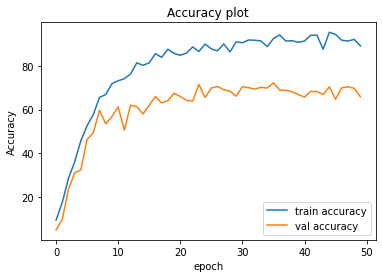

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy2,label='train accuracy')
plt.plot(val_acc2,label='val accuracy')    
plt.legend()

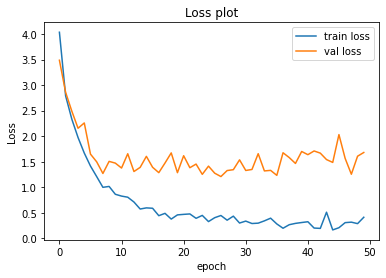

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(loss2,label='train loss')
plt.plot(val_loss2,label='val loss')
    
plt.legend()

In [ ]:
model2.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 2423 test images: 72.34832851836566 %


# Hyperparameter tuning for alexnet model with freiburg dataset

1) Learning rate

In [ ]:
hyper_parameters={"learning_rate":[0.01,0.001,0.0001]}
l=["lr0.01","lr0.001","lr0.0001"]
train_loss_hyper_parameters = {}
train_acc_hyper_parameters={}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for learning_rate in hyper_parameters["learning_rate"]:
    print(f'Results of the learning rate = {learning_rate}')
nested_list=list(hyper_parameters.values())
list_hyper=nested_list[0]
for i in range(0,len(list_hyper)):
  model_hyper=model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
  model_hyper.to(device)
  optimizer_hyper= torch.optim.Adam(model_hyper.parameters(), lr=list_hyper[i])
  criterion_hyper=nn.CrossEntropyLoss()
  train_loader_hyper,test_loader_hyper,val_loader_hyper=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                              test_split=0.2,val_split= 0.2,batch_size=16, input_size=[256,256])  
  print('Training with Learning Rate {}'.format(list_hyper[i]))
  model_hyper,train_loss_hyper,train_accuracy_hyper,val_acc,val_loss = train(model_hyper,train_loader_hyper,val_loader_hyper,criterion_hyper,optimizer_hyper,10)
  train_loss_hyper_parameters[l[i]]=train_loss_hyper
  train_acc_hyper_parameters[l[i]]=train_accuracy_hyper

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 20
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_loss_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()

In [ ]:
num_epochs= 20
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_acc_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()

2) Batch size

In [ ]:
hyper_parameters2={"batch_size":[16,32,64,128]}
b=["b16","b32","b64","b128"]
train_loss_hyper_parameters2 = {}
train_acc_hyper_parameters2={}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for batch_size in hyper_parameters2["batch_size"]:
    print(f'Results of the batch size = {batch_size}')
    ######## Write your code here ##############
nested_list2=list(hyper_parameters2.values())
list_hyper2=nested_list2[0]
for i in range(0,len(list_hyper2)):
  model_hyper2=model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
  model_hyper2.to(device)
  optimizer_hyper2= torch.optim.Adam(model_hyper2.parameters(), lr=0.001)
  criterion_hyper2=nn.CrossEntropyLoss()
  ############ Load dataset ###########
  train_loader_hyper2,test_loader_hyper2,val_loader_hyper2=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                              test_split=0.2,val_split= 0.2,batch_size=list_hyper2[i], input_size=[256,256])
  ############ Call the train function ###########
  print('Training with Batch Size {}'.format(list_hyper2[i]))
  model_hyper2,train_loss_hyper2,train_accuracy_hyper2,val_acc,val_loss = train(model_hyper2,train_loader_hyper2,val_loader_hyper2,criterion_hyper2,optimizer_hyper2,40)
############ Store train_loss, and train_accuracy in the defined dictionaries ###########
  train_loss_hyper_parameters2[b[i]]=train_loss_hyper2
  train_acc_hyper_parameters2[b[i]]=train_accuracy_hyper2

Results of the batch size = 16
Results of the batch size = 32
Results of the batch size = 64
Results of the batch size = 128


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with Batch Size 16
Device: cuda:0
Epoch [1/40], Loss: 3.4871, Accuracy: 5.48%, Validation Loss : 3.1978, Validation Accuracy : 4.13%,
Epoch [2/40], Loss: 3.2013, Accuracy: 6.12%, Validation Loss : 3.1896, Validation Accuracy : 6.45%,
Epoch [3/40], Loss: 3.1874, Accuracy: 5.67%, Validation Loss : 3.1820, Validation Accuracy : 5.77%,
Epoch [4/40], Loss: 3.1718, Accuracy: 5.89%, Validation Loss : 3.1758, Validation Accuracy : 6.96%,
Epoch [5/40], Loss: 3.1719, Accuracy: 6.47%, Validation Loss : 3.1635, Validation Accuracy : 6.98%,
Epoch [6/40], Loss: 3.1680, Accuracy: 6.55%, Validation Loss : 3.1711, Validation Accuracy : 7.00%,
Epoch [7/40], Loss: 3.1665, Accuracy: 6.91%, Validation Loss : 3.1674, Validation Accuracy : 7.00%,
Epoch [8/40], Loss: 3.1672, Accuracy: 6.58%, Validation Loss : 3.1731, Validation Accuracy : 6.98%,
Epoch [9/40], Loss: 3.1650, Accuracy: 7.09%, Validation Loss : 3.1635, Validation Accuracy : 6.96%,
Epoch [10/40], Loss: 3.1631, Accuracy: 6.45%, Validation 

KeyboardInterrupt: ignored

In [ ]:
num_epochs= 40
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for batch_size in hyper_parameters2["batch_size"]:
    plt.plot(epochs,train_loss_hyper_parameters2[f'b{batch_size}'],label=f'Batch Size: {batch_size}')
    
plt.legend()

In [ ]:
num_epochs= 40
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for batch_size in hyper_parameters2["batch_size"]:
    plt.plot(epochs,train_acc_hyper_parameters2[f'b{batch_size}'],label=f'Batch Size: {batch_size}')
    
plt.legend()

3) Loss Function

In [ ]:
hyper_parameters3={"loss_function":['neg_log_likelihood','cross_entropy']}
lf=["lfnneg_log_likelihood","lfncross_entropy"]
train_loss_hyper_parameters3 = {}
train_acc_hyper_parameters3={}
criterion_hypercross=nn.CrossEntropyLoss()
criterion_hypernnloss=nn.NLLLoss()
for loss_function in hyper_parameters3["loss_function"]:
    print(f'Results of the loss function = {loss_function}')
    ######## Write your code here ##############
nested_list3=list(hyper_parameters3.values())
list_hyper3=nested_list3[0]
for i in range(0,len(list_hyper3)):
  model_hyper3=torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
  optimizer_hyper3= torch.optim.Adam(model_hyper.parameters(), lr=0.001)
  train_loader_hyper3,test_loader_hyper3,val_loader_hyper3=load_data(path=r'/content/drive/MyDrive/freiburg_dataset', 
                                              test_split=0.1,val_split= 0.1,batch_size=16, input_size=[64,64])
  ############ Call the train function ###########
  print('Training with Loss function {}'.format(list_hyper3[i]))
  if i==0:
   train_loss_hyper3,train_accuracy_hyper3,val_acc_hyper3,val_loss_hyper3 = train(model_hyper3,train_loader_hyper3,val_loader_hyper3,criterion_hyper3,optimizer_hyper3,30)
  else:
    train_loss_hyper3,train_accuracy_hyper3,val_acc_hyper3,val_loss_hyper3= train(model_hyper3,train_loader_hyper3,val_loader_hyper3,criterion_hyper3,optimizer_hyper3,30)
############ Store train_loss, and train_accuracy in the defined dictionaries ###########
  train_loss_hyper_parameters3[lf[i]]=train_loss_hyper3
  train_acc_hyper_parameters3[lf[i]]=train_accuracy_hyper3

In [ ]:
num_epochs= 30
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for batch_size in hyper_parameters3["loss_function"]:
    plt.plot(epochs,train_loss_hyper_parameters3[f'lf{loss_function}'],label=f'Loss Funcrtion: {loss_function}')
    
plt.legend()

In [ ]:
num_epochs= 30
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for batch_size in hyper_parameters3["loss_function"]:
    plt.plot(epochs,train_acc_hyper_parameters3[f'lf{loss_function}'],label=f'Loss Funcrtion: {loss_function}')
    
plt.legend()